# Relationship between Temperatures and Immigration
### Data Engineering Capstone Project


#### Project Summary

Im this work we are going to find the immigration beahavior between temperatures
and immigration.

We we will build a pipeline considering that you have a Huge amount of data and just
you extract a certain amount of them to do the analsysis.

We introduce a a new method that we are considering is the spliting any huge dataset
into pieces and study them in the pipeline.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

##### How do we use this data model to answer the immigration behavior?

Well after get the table of the results immigration and temperatures
we can plot the frequency of the temperatarures by ranges 
and identify which temperatures has more frequency and indentify which cities
has these teperatures.

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
from pyspark.sql.functions import udf
import psycopg2
import re
import pandas as pd

In [2]:
#spark.version 

### Step 1: Scope the Project and Gather Data

#### Scope 
The scope of this project is to determine the relationship between immigration and temperatures

#### Describe and Gather Data 

I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.


World Temperature Data: This dataset came from Kaggle.
GlobalLandTemperaturesByCity.csv

In this dataset, we have include several files:

Global Land and Ocean-and-Land Temperatures (GlobalTemperatures.csv):

Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
LandAverageTemperature: global average land temperature in celsius
LandAverageTemperatureUncertainty: the 95% confidence interval around the average
LandMaxTemperature: global average maximum land temperature in celsius
LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature
LandMinTemperature: global average minimum land temperature in celsius
LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature
LandAndOceanAverageTemperature: global average land and ocean temperature in celsius
LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

## Data Wrangling
Large datasets always present an extra challenge that needs to be handled with care.
You start to run into hardware roadblocks since you don’t have enough RAM to hold all the data in memory. 

Enterprise companies store datasets that get up to the range of 100s or even 1000s of GBs .

 This article will use one technique to reduce the memory footprint and read-in time for your large dataset. 
 
#### Chunking your data
CSV format is a very convenient way to store data, being both easy to write to and human readable. When the CSV is so big that and we run out of memory instead trying to handle our data all at once, we’re going to do it in pieces. Typically, these pieces are referred to as chunks.
A chunk is just a part of our dataset. We can make that chunk as big or as small as we want. It just depends on how much RAM we have.
The process then works as follows:
1. Read in a chunk Process the chunk
2. Save the results of the chunks 
3. Merge all the chunk results

We can perform all of the above steps using a handy variable of the read_csv() function called chunksize.
The chunksize refers to how many CSV rows pandas will read at a time. This will of course depend on how much RAM you have and how big each row is.


In [4]:
# Read April 2016 I94 immigration data as Udacity example
immigration = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'

## Immigration dataset

In ordering to deal with big data , sometimes you require a lot of memory, so to avoid this issue we can split the data by chunks.

In [5]:
def split_large_data_sas(path,file):
#    We create chunks of the big dataset
# path : path where I want save the chunks
# file : path of the large dataset
    path_name=path+'chunk'
    chunk_size=100000
    batch_no=1
    for chunk in pd.read_sas(file, encoding="ISO-8859-1",chunksize=chunk_size):
        chunk.to_csv(path_name+str(batch_no)+'.csv',index=False)
        batch_no+=1

Importing a single chunk file into pandas dataframe:
We now have multiple chunks, and each chunk can easily be loaded as a pandas dataframe.

In [6]:
split_large_data_sas("./data/",immigration)

We count the number  of chunks created

In [7]:
def fileCount(folder,extension):
    import glob
    count = len(glob.glob1(folder,"*."+extension))
    return count

In [8]:
csv_chunks=fileCount("./data/","csv")
print(" We have created "+ str(csv_chunks) +" chunks of Immigration data")

 We have created 31 chunks of Immigration data


In [9]:
df_immigration1 = pd.read_csv('./data/chunk1.csv')
df_immigration1.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


## Temperature dataset

In [10]:
# Read in the temperature data
temperature_data = '../../data2/GlobalLandTemperaturesByCity.csv'


In [12]:
def split_large_data_csv(path,file):
# We create chunks of the big dataset
# path : path where I want save the chunks
# file : path of the large dataset
#    We create chunks of the big dataset
    path_name=path+'chunk'
    chunk_size=100000
    batch_no=1
    for chunk in pd.read_csv(file,chunksize=chunk_size):
        chunk.to_csv(path_name+str(batch_no)+'.csv',index=False)
        batch_no+=1

In [13]:
split_large_data_csv("./data2/",temperature_data)

In [14]:
csv2_chunks=fileCount("./data2/","csv")
print(" We have created "+ str(csv2_chunks) +" chunks of Temperature data")

 We have created 86 chunks of Temperature data


In [15]:
df_temperature_data1 = pd.read_csv('./data2/chunk1.csv')


In [16]:
# Display first 5 rows of df_temp
df_temperature_data1.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


## Spark SQL, DataFrames and Datasets
Spark SQL is a Spark module for structured data processing. 

Internally, Spark SQL uses this extra information to perform extra optimizations.

There are several ways to interact with Spark SQL including SQL and the Dataset API. 



SQL
One use of Spark SQL is to execute SQL queries. Spark SQL can also be used to read data from an existing Hive installation.
When running SQL from within another programming language the results will be returned as a Dataset/DataFrame.


#### Datasets vs DataFrames
A **Dataset** is a distributed collection of data. Dataset is a new interface added in Spark 1.6 that provides the benefits of RDDs (strong typing, ability to use powerful lambda functions) with the benefits of Spark SQL’s optimized execution engine. 

A Dataset can be constructed from JVM objects and then manipulated using functional transformations (map, flatMap, filter, etc.). The Dataset API is available in Scala and Java. 

Python does not have the support for the Dataset API. But due to Python’s dynamic nature, many of the benefits of the Dataset API are already available (i.e. you can access the field of a row by name naturally row.columnName).

A **DataFrame** is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs. The DataFrame API is available in Scala, Java, Python, and R. In Scala and Java, a DataFrame is represented by a Dataset of Rows.
In the Scala API, DataFrame is simply a type alias of Dataset[Row]. While, in Java API, users need to use Dataset<Row> to represent a DataFrame.


In [17]:
# We install the librarires needed
#pip install py4j
#pip install pyspark

In [18]:
# Create Spark session 
from pyspark.sql import SparkSession

In [20]:
# If we load only one chunk of the Immigration Data

In [21]:
spark1 = SparkSession.builder.appName('Ops').getOrCreate()
dfspark1=spark1.read.csv('./data/chunk1.csv',inferSchema=True,header=True)
###Print the Schema
dfspark1.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: integer (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable =

In [22]:
# If we load only one chunk of the Temperature Data

In [23]:
spark2 = SparkSession.builder.appName('Ops').getOrCreate()
dfspark2=spark2.read.csv('./data2/chunk1.csv',inferSchema=True,header=True)
###Print the Schema
dfspark2.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



### Step 2: Explore and Assess the Data
#### Explore the Data 

We remove the non valid data from the  I94 immigration dataset.


In [24]:
# Dictionary of valid i94port codes is created
re_obj = re.compile(r'\'(.*)\'.*\'(.*)\'')
i94portvalid = {}
with open('i94port.txt') as f:
     for data in f:
         match = re_obj.search(data)
         i94portvalid[match[1]]=[match[2]]

In [25]:
# Clean immigration data full dataset
def clean_immigration_data(file):
    '''    
    Input: Path to immigration data file
    Output: Spark dataframe of immigration data with valid i94port
    '''    
    # Read I94 data into Spark
    df_immigration = spark.read.format('com.github.saurfang.sas.spark').load(file)
    # Filter out entries where i94port is invalid
    df_immigration = df_immigration.filter(df_immigration.i94port.isin(list(i94portvalid.keys())))
    return df_immigration

## Cleaning single chunk 

#### Inmigration data

In [26]:
# Clean immigration data
def clean_immigration_data1(file):
    '''    
    Input: Path to immigration data file
    Output: Spark dataframe of immigration data with valid i94port
    '''    
    # Read I94 data into Spark
    spark1 = SparkSession.builder.appName('Ops').getOrCreate()
    df_immigration=spark1.read.csv(file,inferSchema=True,header=True)
    # Filter out entries where i94port is invalid
    df_immigration = df_immigration.filter(df_immigration.i94port.isin(list(i94portvalid.keys())))
    return df_immigration

In [27]:
#type(df_immigration_test)

In [28]:
# Test function
immigration_test_file = './data/chunk1.csv' 
df_immigration_test = clean_immigration_data1(immigration_test_file)
#df_immigration_test.show(5)

#### Temperature data

In [ ]:

We remove the data points where AverageTemperature is NaN, duplicate locations, and we include the i94port of the location.

In [29]:
# Clean temperature data
df_temperature_data1 = spark.read.format("csv").option("header", "true").load("../../data2/GlobalLandTemperaturesByCity.csv")

In [30]:
#df_temperature_data1 = spark.read.format("csv").option("header", "true").load("./data2/chunk1.csv")

In [31]:
#df_temperature_data1.show(10)

In [32]:
# Filter out data points with NaN average temperature
df_temperature_data1 = df_temperature_data1.filter(df_temperature_data1.AverageTemperature != 'NaN')

In [33]:
#df_temperature_data1.show(10)

In [34]:

# We define the key port
@udf()
def get_i94port(city):
    for key in i94portvalid:
        if city.lower() in i94portvalid[key][0].lower():
            return key
    

In [35]:
# Add iport94 code based on city name
df_temperature_data1 = df_temperature_data1.withColumn("i94port", get_i94port(df_temperature_data1.City))
#df_temperature_data1.show()

In order to Extract First N rows in pyspark we will be using functions like show() function and head() function. 



In [36]:
#Extract First row of dataframe in pyspark – using first() function.
########## Extract first row of the dataframe in pyspark
df_temperature_data1.first()

Row(dt='1743-11-01', AverageTemperature='6.068', AverageTemperatureUncertainty='1.7369999999999999', City='Århus', Country='Denmark', Latitude='57.05N', Longitude='10.33E', i94port=None)

In [37]:
########## Extract first N row of the dataframe in pyspark – show()
df_temperature_data1.show(5)

+----------+------------------+-----------------------------+-----+-------+--------+---------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|i94port|
+----------+------------------+-----------------------------+-----+-------+--------+---------+-------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|   null|
|1744-04-01|5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|   null|
|1744-05-01|            10.644|           1.2830000000000001|Århus|Denmark|  57.05N|   10.33E|   null|
|1744-06-01|14.050999999999998|                        1.347|Århus|Denmark|  57.05N|   10.33E|   null|
|1744-07-01|            16.082|                        1.396|Århus|Denmark|  57.05N|   10.33E|   null|
+----------+------------------+-----------------------------+-----+-------+--------+---------+-------+
only showing top 5 rows



In [38]:
########## Extract first N row of the dataframe in pyspark – head()
#df_temperature_data1.head(3)

In [39]:
########## Extract first N row of the dataframe in pyspark – take()
#df_temperature_data1.take(2)

Drop Rows with NULL Values on Selected Columns
In order to remove Rows with NULL values on selected columns of PySpark DataFrame, use drop(columns:Seq[String]) or drop(columns:Array[String]). To these functions pass the names of the columns you wanted to check for NULL values to delete rows.

In [40]:
#df_temperature_data_drop=df_temperature_data1.na.drop(subset=["i94port"]) \
#   .show(truncate=False)

In [41]:
df_temperature_data_drop=df_temperature_data1.na.drop(subset=["i94port"])

In [42]:
#df_temperature_data_drop.show()

In [43]:
# Remove data points with no iport94 code
df_temperature_data1 = df_temperature_data1.filter(df_temperature_data1.i94port != 'null')

In [44]:
# Show results
#df_temperature_data1.show()

In [45]:
# Clean immigration data
def clean_temperature_data1(file):
    df_temperature_data1 = spark.read.format("csv").option("header", "true").load(file)
    # Filter out data points with NaN average temperature
    df_temperature_data1 = df_temperature_data1.filter(df_temperature_data1.AverageTemperature != 'NaN')
    # Add iport94 code based on city name
    df_temperature_data1 = df_temperature_data1.withColumn("i94port", get_i94port(df_temperature_data1.City))
    # Remove data points with no iport94 code
    df_temperature_data1 = df_temperature_data1.filter(df_temperature_data1.i94port != 'null')
    return df_temperature_data1

In [46]:

path2="./data2/chunk1.csv"

In [47]:
df_temperature_data1b=clean_temperature_data1(path2)

In [48]:
# Show results
#df_temperature_data1b.show()

In [49]:
df_temperature_data1b.schema

StructType(List(StructField(dt,StringType,true),StructField(AverageTemperature,StringType,true),StructField(AverageTemperatureUncertainty,StringType,true),StructField(City,StringType,true),StructField(Country,StringType,true),StructField(Latitude,StringType,true),StructField(Longitude,StringType,true),StructField(i94port,StringType,true)))

## Clean multiple chunks

We can clean the multiple chunks by cleaning single chunks iteratively and combine them into a big dataframe in pyspark.

PySpark provides multiple ways to combine dataframes i.e. join, merge, union, SQL interface, etc. 


We will take a look at how the PySpark join function is similar to SQL join, where two or more tables or dataframes can be combined based on conditions. 

Let's take a look at some of the join operations supported by PySpark .



In [50]:
from pyspark.sql import SparkSession

#### Example of merging

First, we choose two dataframes

In [51]:
df_immigration_test1=clean_immigration_data1('./data/chunk1.csv')
df_immigration_test2=clean_immigration_data1('./data/chunk2.csv')

In [52]:
print((df_immigration_test1.count(), len(df_immigration_test1.columns)))
print((df_immigration_test2.count(), len(df_immigration_test2.columns)))

(99905, 28)
(99891, 28)


Sometime, when the dataframes to combine do not have the same order of columns, it is better to df2.select(df1.columns) in order to ensure both df have the same column order before the union.

In [53]:
import functools 
def unionAll(dfs):
    return functools.reduce(lambda df1,df2: df1.union(df2.select(df1.columns)), dfs) 

In [54]:
unioned_df = unionAll([df_immigration_test1,df_immigration_test2])

In [55]:
print((unioned_df.count(), len(unioned_df.columns)))

(199796, 28)


In [56]:
#Which is the method that we will consider.

In addition if all df have the same column order before the union we can use

In [57]:
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame
def unionAllsame(*dfs):
    return reduce(DataFrame.unionAll, dfs) 


In [58]:
unioned_df_same = unionAllsame([df_immigration_test1,df_immigration_test2])

However for this project he prefer *unionAll* definition.


### Cleaning Multiple Chunks for Data Immigration

Now we create a function that create a big dataframe in Pyspark

For lack of time just I presnet the firsts chunks. In a real project we should consider all of them

In [59]:
def clean_large_data_sas(path):
# We create clean alll the chunks of the big dataset
# path : path where I want save the chunks
    path_name=path+'chunk'
    csv_chunks=fileCount("./data/","csv")
    chunk_size=2#csv_chunks
    batch_no=1
     # We create  an empty df1 Pyspark Dataframe with schema            
    schemas=clean_immigration_data1(path_name+str(batch_no)+'.csv').schema
    df1 = spark.createDataFrame([], schemas)
    
    for chunk in range(chunk_size):
        file=path_name+str(batch_no)+'.csv'
        #print(file)
        df_immigration_chunk= clean_immigration_data1(file)
        #print((df_immigration_chunk.count(), len(df_immigration_chunk.columns)))
        df1 = unionAll([df1,df_immigration_chunk])
       # df_immigration_chunk.show()
        #df1.show()
        #print((df1.count(), len(df1.columns)))
        batch_no+=1
    return df1


In [60]:
df_immigration_all=clean_large_data_sas("./data/")

In [61]:
#df_immigration_all.show()

### Cleaning Multiple Chunks for Temperature data

In [62]:
def clean_large_data_csv(path):
# We create clean alll the chunks of the big dataset
# path : path where I want save the chunks
    path_name=path+'chunk'
    csv_chunks=fileCount("./data2/","csv")
    chunk_size=2 #csv_chunks
    batch_no=1
     # We create  an empty df1 Pyspark Dataframe with schema            
    schemas=clean_temperature_data1(path_name+str(batch_no)+'.csv').schema
    df1 = spark.createDataFrame([], schemas)
    for chunk in range(chunk_size):
        file=path_name+str(batch_no)+'.csv'
        #print(file)
        df_temperature_data1=clean_temperature_data1(file)
        df1 = unionAll([df1,df_temperature_data1])
        #df1.show()
        #print((df1.count(), len(df1.columns)))
        batch_no+=1
    return df1    


In [63]:
df_temperature_all=clean_large_data_csv("./data2/")

In [64]:
#df_temperature_all.show()

### Step 3: Define the Data Model

#### 3.1 Conceptual Data Model
**Result Table** - I94 immigration data joined with the city temperature data on i94port,
Columns:
   - i94yr = 4 digit year,
   - i94mon = numeric month,
   - i94cit = 3 digit code of origin city,
   - i94port = 3 character code of destination USA city,
   - arrdate = arrival date in the USA,
   - i94mode = 1 digit travel code,
   - depdate = departure date from the USA,
   - i94visa = reason for immigration,
   - AverageTemperature = average temperature of destination city,

#### 3.2 Mapping Out Data Pipelines\n

Pipeline Steps:

1. We define the paths of the source files of immigration data.
2. Split data of the I94 immigration data into chuncks
3. We have to clean the data of the I94 dataset of all chunks 
4. We extract columns that are useful for the analsyis
5. Optionally we create a paquet file of the immigration data partitioned by i94port.
6. Split data of the temperautre  data into chuncks
7. Clean the temperatures dataset and we create a  Spark dataframe df_temperature_data.
8. Optionally we can create a parquet file of the temperatures table partitioned by i94port.
9. Create result table by merging immigration and temperature tables
10. We write the results table in  parquet file 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [65]:
# 1- Path to I94 immigration data
#immigration_data = '/data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'

In [66]:
# 2-Split data
#split_large_data_sas("../../data/",immigration)

In [67]:
# 3-Clean I94 immigration data and store as Spark dataframe
#df_immigration_all=clean_large_data_sas("./data/")

In [68]:
df_immigration=df_immigration_all

In [69]:
#4-  Extract columns for immigration 
immigration_table = df_immigration.select(["i94yr", "i94mon", "i94cit", "i94port", "arrdate", "i94mode", "depdate", "i94visa"])

Columnar storage like Apache Parquet is designed to bring efficiency compared to row-based files like CSV. When querying, columnar storage you can skip over the non-relevant data very quickly. As a result, aggregation queries are less time consuming compared to row-oriented databases.

In [70]:
#5- Write immigration table to parquet files partitioned by i94port
#immigration_table.write.mode("append").partitionBy("i94port").parquet("./data/immigration.parquet")

In [71]:
# 6Read in the temperature data
#temperature_data = '../../data2/GlobalLandTemperaturesByCity.csv'
#split_large_data_csv("./data2/",temperature_data)

In [72]:
#df_temperature_all=clean_large_data_csv("./data2/")

In [73]:
df_temperature_data1=df_temperature_all

In [74]:
#7 Extract columns for temperature  table
temp_table = df_temperature_data1.select(["AverageTemperature", "City", "Country", "Latitude", "Longitude", "i94port"])

In [75]:
#8 Write temperature dimension table to parquet files partitioned by i94port
#temp_table.write.mode("append").partitionBy("i94port").parquet("./data2/temperature.parquet")

In [76]:
#  We create table of results of the immigration and temperature data
df_immigration.createOrReplaceTempView("immigration_view")
df_temperature_data1.createOrReplaceTempView("temperature_view")

In [77]:
# 9 We werge the information of temperature and immigration
result_table = spark.sql('''
select immigration_view.i94yr as year,
       immigration_view.i94mon as month,
       immigration_view.i94cit as city,
       immigration_view.i94port as i94port,
       immigration_view.arrdate as arrival_date,
       immigration_view.depdate as departure_date,
       immigration_view.i94visa as reason,
       temperature_view.AverageTemperature as temperature,
       temperature_view.Latitude as latitude,
       temperature_view.Longitude as longitude
from immigration_view
JOIN temperature_view ON (immigration_view.i94port = temperature_view.i94port)
''')

In [78]:
#10 improve the writting of parquet
n = 2 # number of repartitions, try 2 to test
path="./results/result.parquet"
spark_df  = result_table.repartition(n)
spark_df.write.mode("overwrite").partitionBy("i94port").parquet(path)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 
Run Quality Checks

In [80]:
def quality_check(df, description):
    '''
    Input: Spark dataframe, description of Spark datafram
    Output: Print outcome of data quality check
    '''
    
    result = df.count()
    if result == 0:
        print("Data quality check failed for {} with zero records".format(description))
    else:
        print("Data quality check passed for {} with {} records".format(description, result))
    return 0

In [81]:
# Perform data quality check
#quality_check(df_immigration, "immigration table")
#quality_check(df_temperature_data1, "temperature table")

Data quality check passed for immigration table with 3088544 records
Data quality check passed for temperature table with 539191 records
0

#### 4.3 Data dictionary 

**Results Table** - 
Columns:
   - i94yr = 4 digit year,
   - i94mon = numeric month,
   - i94cit = 3 digit code of origin city,
   - i94port = 3 character code of destination USA city,
   - arrdate = arrival date in the USA,
   - i94mode = 1 digit travel code,
   - depdate = departure date from the USA,
   - i94visa = reason for immigration,
   - AverageTemperature = average temperature of destination city,


## Analysis  of the Results

Spark Actions:
spark dataframe does not contain data, it contains instructions and operation graph, since spark works with big data it does not allow to perform any operation as its called, to prevent slow performance, instead, methods are separated into two kinds Actions and Transformations, transformations are collected and contained as an operation graph.

Action is a method that causes the dataframe to execute all accumulated operation in the graph, causing the slow performances, since it execute everything (note, UDFs are extremely slow).

show() is an action, when you call show() it has to calculate every other transformation to show you the true data.

 We want to analyze the database to see the immigration behaviour to location temperatures.

### Reading The Results in Parquet


In [82]:
from pyspark.sql import SparkSession
# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()
sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


In [83]:
df=result_table

In [84]:
type(df)

pyspark.sql.dataframe.DataFrame

In [85]:
df.sample(False, 0.1, seed=0)

DataFrame[year: double, month: double, city: double, i94port: string, arrival_date: double, departure_date: double, reason: double, temperature: string, latitude: string, longitude: string]

In [86]:
df.printSchema()

root
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- city: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrival_date: double (nullable = true)
 |-- departure_date: double (nullable = true)
 |-- reason: double (nullable = true)
 |-- temperature: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



In [90]:
# to read parquet file
df = sqlContext.read.parquet('./results/result.parquet')

In [91]:
df.printSchema()

root
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- city: double (nullable = true)
 |-- arrival_date: double (nullable = true)
 |-- departure_date: double (nullable = true)
 |-- reason: double (nullable = true)
 |-- temperature: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- i94port: string (nullable = true)



In [88]:
import pandas as pd

In [92]:
# convert to pandas and plot
pdf = df.toPandas()

In [93]:
pdf.head()

,year,month,city,arrival_date,departure_date,reason,temperature,latitude,longitude,i94port
0,2016.0,4.0,274.0,20546.0,20555.0,2.0,31.88300000000001,24.92N,54.98E,MAA
1,2016.0,4.0,213.0,20545.0,20557.0,1.0,17.230999999999998,24.92N,54.98E,MAA
2,2016.0,4.0,213.0,20545.0,20557.0,1.0,17.230999999999998,24.92N,54.98E,MAA
3,2016.0,4.0,213.0,20545.0,20639.0,2.0,30.089,24.92N,54.98E,MAA
4,2016.0,4.0,244.0,20545.0,NaN,3.0,19.679,24.92N,54.98E,MAA


In [ ]:
from pandas.plotting import scatter_matrix

In [96]:
cols = pdf.columns.drop('i94port')

In [97]:
pdf[cols] = pdf[cols].apply(pd.to_numeric, errors='coerce')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc84e8f630>]], dtype=object)

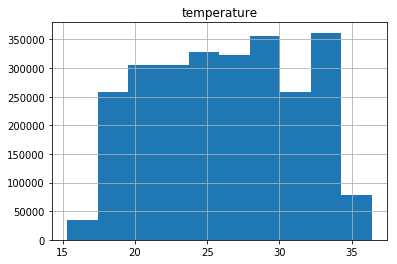

In [100]:
import matplotlib.pyplot as plt
pdf.hist(column='temperature')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc84e86a58>]], dtype=object)

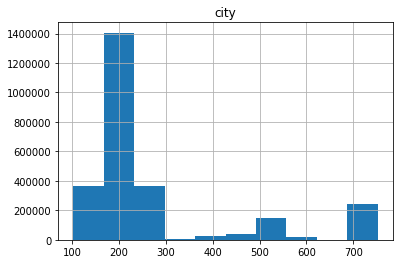

In [101]:
import matplotlib.pyplot as plt
pdf.hist(column='city')

In [111]:
pdf_city=pdf.loc[(pdf['city'] <= 300)& (pdf['temperature'] >= 25) ]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc85719198>]], dtype=object)

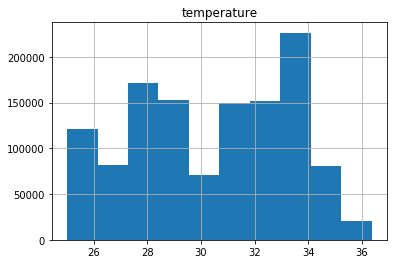

In [112]:
import matplotlib.pyplot as plt
pdf_city.hist(column='temperature')

That means that there is more inmmigration cases to the cities where the temperature as around 32 to 34 degrees

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project:

The strategy of this project depends on the **amount of data** that you have to process in your ETL.
In this project I assume that the amount of that is relly big and the amount of resources in **memory** is limited.


1. In ordering to del with this great amount of that we should split in chunks.

<img src="sharding-range-based.bakedsvg.svg" width="400">



2. In ordring to have performance in the large scale data processing we use pache Spark

<img src="largest-open-source-apache-spark.png" width="400">

a) Engineered from the bottom-up for performance, Spark can be 100x faster than Hadoop for large scale data processing by exploiting in memory computing and other optimizations. Spark is also fast when data is stored on disk, and currently holds the world record for large-scale on-disk sorting.

b) Spark has easy-to-use APIs for operating on large datasets. This includes a collection of over 100 operators for transforming data and familiar data frame APIs for manipulating semi-structured data.

c) Spark comes packaged with higher-level libraries, including support for SQL queries, streaming data, machine learning and graph processing. These standard libraries increase developer productivity and can be seamlessly combined to create complex workflows.

d) In additon Spark can andle multiple file formats (SAS, csv, etc) that contain large amounts of data.  Spark SQL was used to process the input files into dataframes and manipulated via standard SQL join operations to create the tables.



### Scenarios
* Write a description of how you would approach the problem differently under the following scenarios:


1. We can use this pipeline when the amount of that is bigger than 100Gb
     The AWS service  we can use is  Amazon Redshift: It is an analytical database that is optimized for aggregation and read-heavy workloads



2. The data populates a dashboard that must be updated on a daily basis by 6 am every day before people people wake up.
  
  
3.  Apache Airflow is a scheduler to manage your regular jobs. It is an excellent tool to organize, execute, and monitor your workflows so that they work seamlessly. Apache Airflow solved a lot of problems that the predecessors faced.
  
4.  So we can use Ariflow to create DAG retries or send emails on failures and perform daily quality checks; if fail, send emails to operators and freeze dashboards


5. The database needed to be accessed by many people.
    Amazon Redshift makes it easy to add nodes to your data warehouse and enables you to maintain fast query performance as your data warehouse grows. Redshift Spectrum: Redshift Spectrum enables you to run queries against exabytes of data in Amazon S3